In [2]:
# 1. Import Libraries  
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from textblob import TextBlob 
import sqlite3

In [3]:
# 2. Load Multiple CSV Files Example: 6 regions - US, IN, GB, CA, DE, FR files = { "US": "US_trending.csv", "IN": "IN_trending.csv", "GB": "GB_trending.csv", "CA": "CA_trending.csv", "DE": "DE_trending.csv", "FR": "FR_trending.csv" }
files = {
    "US": "US_trending.csv",
    "IN": "IN_trending.csv",
    "GB": "GB_trending.csv",
    "CA": "CA_trending.csv",
    "DE": "DE_trending.csv",
    "FR": "FR_trending.csv"
}


In [4]:
# Load and merge with region column
df_list = [] 
for region, file in files.items():
    temp = pd.read_csv(file) 
    temp["region"] = region 
    df_list.append(temp)

merged_df = pd.concat(df_list, ignore_index=True)
print("Dataset shape:", merged_df.shape) 
print("Columns:", merged_df.columns)


Dataset shape: (1200, 8)
Columns: Index(['video_id', 'title', 'channel', 'publishedAt', 'views', 'likes',
       'comments', 'region'],
      dtype='object')


In [5]:
# 3. Data Cleaning 
# Standardize column names 
merged_df.columns = merged_df.columns.str.lower().str.replace(" ", "_")
# Convert dates 
merged_df["publishedat"] = pd.to_datetime(merged_df["publishedat"], errors="coerce") 
if "publish_time" in merged_df.columns:
	merged_df["publish_time"] = pd.to_datetime(merged_df["publish_time"], errors="coerce")
if "trending_date" in merged_df.columns:
	merged_df["trending_date"] = pd.to_datetime(merged_df["trending_date"], errors="coerce") 
# Remove duplicates 
merged_df.drop_duplicates(inplace=True) 
# Handle missing values 
if "tags" in merged_df.columns:
	merged_df.fillna({"tags": "No Tags"}, inplace=True)

In [6]:
# 4. Sentiment Analysis 
def get_sentiment(text): 
    analysis = TextBlob(str(text)) 
    if analysis.sentiment.polarity > 0: 
        return "Positive" 
    elif analysis.sentiment.polarity == 0:
        return "Neutral" 
    else: 
        return "Negative" 

merged_df["title_sentiment"] = merged_df["title"].apply(get_sentiment) 
if "tags" in merged_df.columns:
    merged_df["tags_sentiment"] = merged_df["tags"].apply(get_sentiment)

In [7]:
# 5. SQL Analysis
# Create SQLite connection
conn = sqlite3.connect(':memory:')  # Create an in-memory database

# Use SQLite connection and merged_df
merged_df.to_sql("youtube_trending", conn, if_exists="replace", index=False)
# Example query: Top categories by avg views 
query = """ 
SELECT channel, AVG(views) AS avg_views 
FROM youtube_trending 
GROUP BY channel 
ORDER BY avg_views DESC 
LIMIT 10; """ 
sql_result = pd.read_sql(query, conn) 
print(sql_result)

                channel   avg_views
0  People Media Factory  20439101.0
1              Play DMF  13052025.0
2             Zé Felipe   8096587.0
3          Taylor Swift   7734572.0
4       T-Series Telugu   5282001.0
5         Speed Records   4378253.0
6     Think Music India   3842742.0
7             FORMULA 1   3694129.0
8      LALIGA EA SPORTS   3548555.0
9        ElAlfaElJefeTV   3315077.0


In [8]:
# 6. Time-Series & Trends
# Calculate trending duration
if "trending_date" in merged_df.columns:
    merged_df["days_trending"] = (merged_df["trending_date"] - merged_df["publishedat"]).dt.days

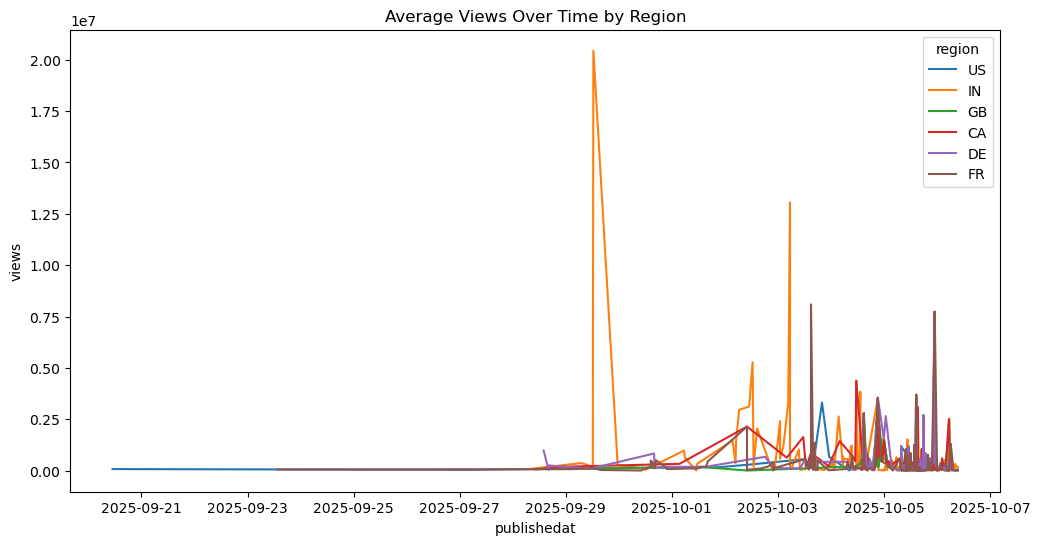

In [9]:
# Plot: Views over time by region 
plt.figure(figsize=(12,6)) 
sns.lineplot(data=merged_df, x="publishedat", y="views", hue="region", estimator="mean")
plt.title("Average Views Over Time by Region")
plt.show()

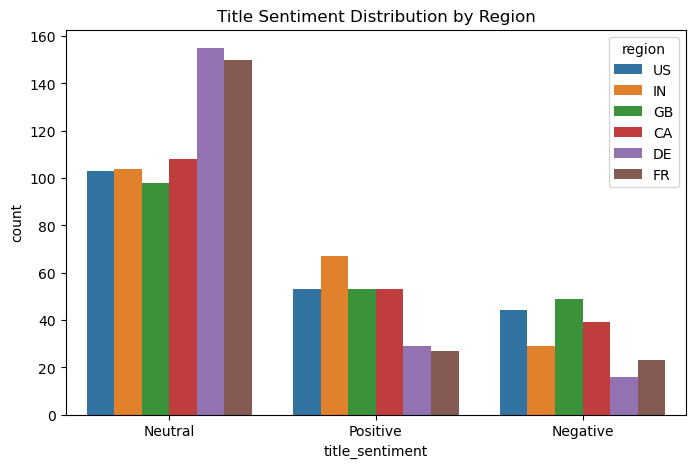

In [10]:
# Sentiment distribution 
plt.figure(figsize=(8,5)) 
sns.countplot(data=merged_df, x="title_sentiment", hue="region") 
plt.title("Title Sentiment Distribution by Region") 
plt.show()

In [11]:
# 7. Export Cleaned Data for Tableau
merged_df.to_csv("cleaned_youtube_trending.csv", index=False)
print("Cleaned dataset saved for Tableau.")

Cleaned dataset saved for Tableau.


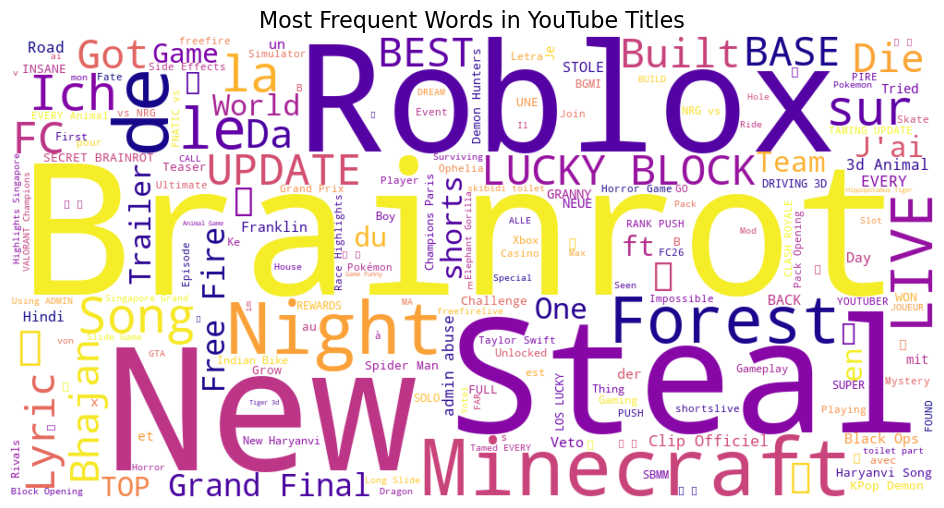

In [17]:
# --- WORD CLOUD ---
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df = pd.read_csv("cleaned_youtube_trending.csv")

# Combine all titles into one text
text = " ".join(title for title in df['title'].astype(str))

# Define stopwords to remove common words
stopwords = set(STOPWORDS)
stopwords.update(["youtube", "video", "official", "music"])

# Generate WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color="white",
                      stopwords=stopwords, colormap="plasma").generate(text)

# Display WordCloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in YouTube Titles", fontsize=16)
plt.show()


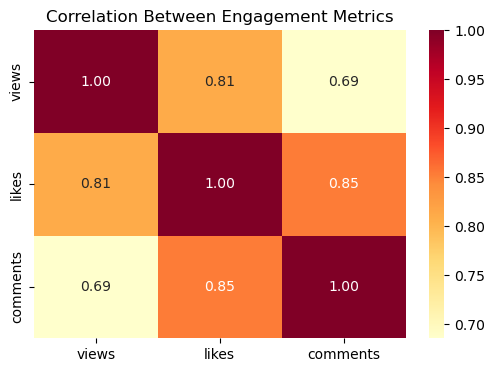

In [18]:
# --- HEATMAP ---
import seaborn as sns
import numpy as np

# Select numeric columns
num_cols = ['views', 'likes', 'comments']

# Calculate correlation matrix
corr = df[num_cols].corr()

# Plot Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title("Correlation Between Engagement Metrics")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_22476\3723471763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_views, x='region', y='views', palette='mako')


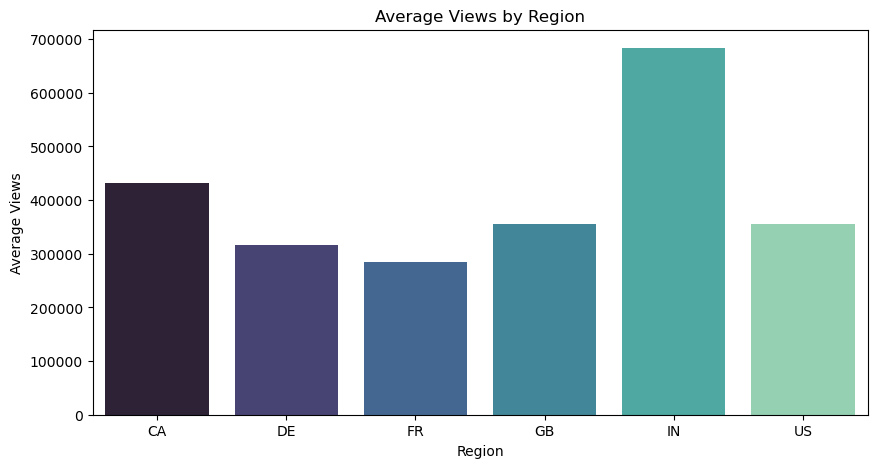

In [15]:
# --- REGION-WISE HEATMAP ---
region_views = df.groupby('region')['views'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=region_views, x='region', y='views', palette='mako')
plt.title("Average Views by Region")
plt.xlabel("Region")
plt.ylabel("Average Views")
plt.show()
